# The dataset we use can be found on the Kaggle website
### https://www.kaggle.com/c/store-sales-time-series-forecasting/data

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


In [93]:
train_data = pd.read_csv("train.csv")
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [94]:
test_data = pd.read_csv("test.csv")
test_data.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Splitting the Date Column
 The `date` column is composed of three components: year, month, and day. To facilitate time-based analysis, we split this column into separate `year`, `month`, and `day` columns, and convert each of them to integers.

In [95]:

train_data[['year', 'month', 'day']] = train_data['date'].str.split('-', expand=True).astype(int)
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1


### Extracting Time-Based Features

To capture temporal patterns in the sales data, we extract additional features from the `date` column:

- `dayofweek`: Integer from 0 (Monday) to 6 (Sunday), indicating the day of the week.
- `weekofyear`: ISO calendar week number of the year, useful for identifying seasonal trends.
- `is_weekend`: Binary indicator (1 if Saturday or Sunday, 0 otherwise), which may influence shopping behavior.

These features help the model understand weekly cycles and seasonal sales behavior.


In [96]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['dayofweek'] = train_data['date'].dt.dayofweek
train_data['weekofyear'] = train_data['date'].dt.isocalendar().week
train_data['is_weekend'] = train_data['dayofweek'].isin([5, 6]).astype(int)

In [97]:
sales = train_data['sales']

# Exploratory Data Analysis

In [98]:
print(train_data.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
dayofweek      0
weekofyear     0
is_weekend     0
dtype: int64


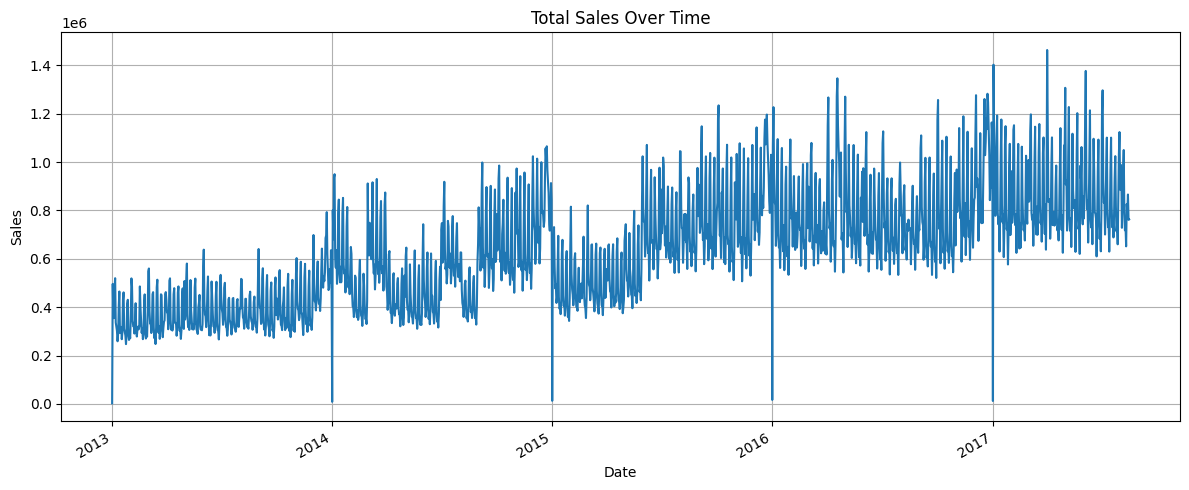

In [99]:
plt.figure(figsize=(12, 5))
train_data.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Sales Over Time

- A clear upward trend in sales over the years, indicating business growth.
- Recurring seasonal patterns, likely linked to holidays and promotional events.
- Several sharp drops in sales, which may correspond to holidays when stores were closed or data gaps.

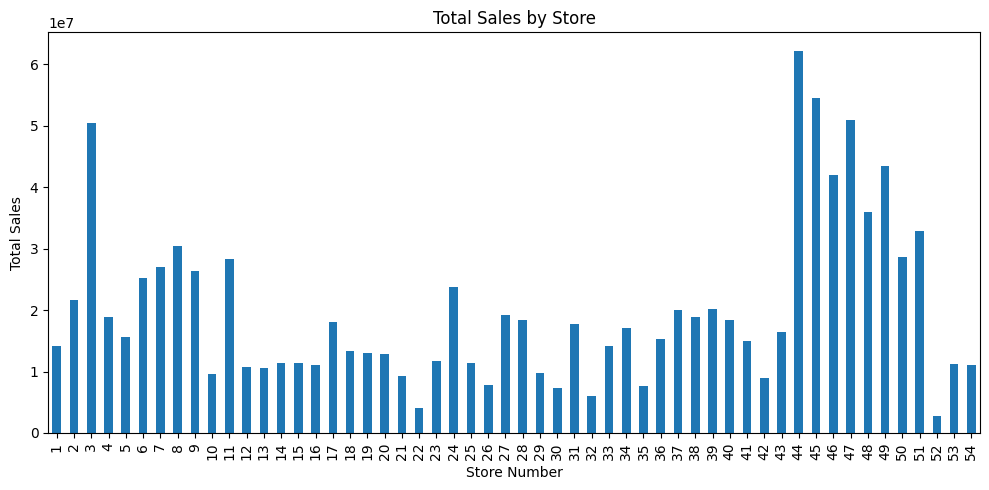

In [100]:
store_sales = train_data.groupby('store_nbr')['sales'].sum().sort_index()

plt.figure(figsize=(10, 5))
store_sales.plot(kind='bar')
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

## Total Sales by Store

#### This bar chart displays the total sales for each store over the entire time period.

- Store 44, 45, and 47 show the highest overall sales, indicating they are likely high-traffic or high-performing locations.
- There is considerable variation in total sales between stores, suggesting differences in location size, customer base, or product availability.
- Some stores, such as Store 22 and Store 52, have noticeably lower sales volumes.

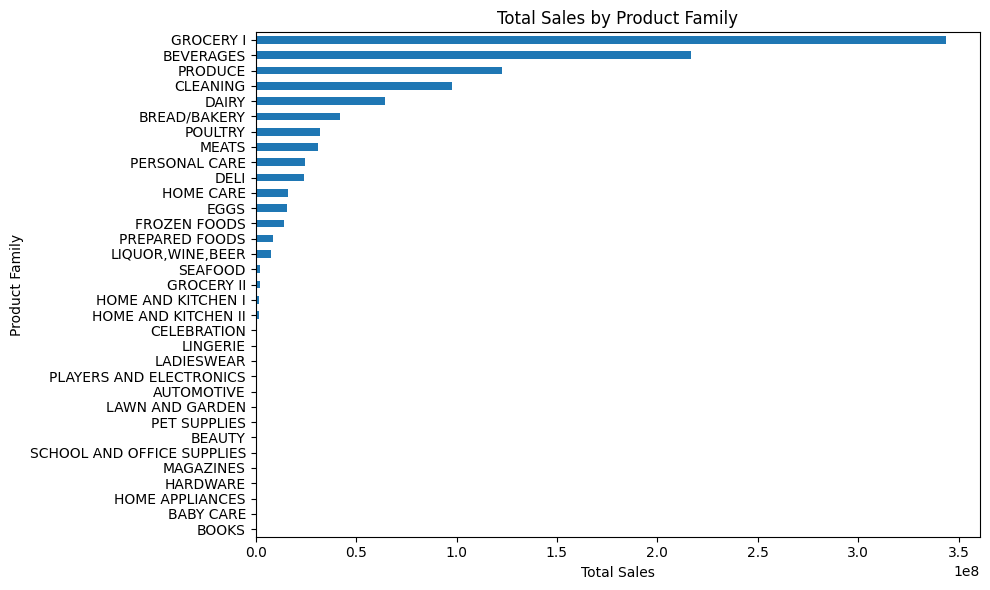

In [101]:
family_sales = train_data.groupby('family')['sales'].sum().sort_values()

plt.figure(figsize=(10, 6))
family_sales.plot(kind='barh')
plt.title('Total Sales by Product Family')
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

## Total Sales by Product Family

#### This horizontal bar chart shows the total sales for each product family across all stores and dates.

Key insights:
- GROCERY I and BEVERAGES are the top-selling categories by a large margin, suggesting they are core drivers of revenue.
- Categories like BOOKS, BABY CARE, and HOME APPLIANCES generate significantly lower sales.

### First model

In [102]:
train_data = train_data.sort_values('date')
train_data['target'] = train_data.groupby(['store_nbr', 'family'])['sales'].shift(-1)
train_data = train_data.dropna(subset=['target'])
train_data['target'] = train_data['target'].astype(int)

In [103]:
train_data.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
year                    int64
month                   int64
day                     int64
dayofweek               int32
weekofyear             UInt32
is_weekend              int64
target                  int64
dtype: object

In [104]:
X = train_data.drop(['sales', 'id', 'date', 'target', 'family'], axis=1)
y = train_data['target']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [106]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [107]:
y_fit  = model.predict(X_train)
y_pred = model.predict(X_test)

In [108]:
mae = mean_absolute_error(y_train, y_fit)

print(f"Training MAE: {mae:.2f}")

Training MAE: 444.23


In [109]:
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {test_mae:.2f}")

Test MAE: 562.78


In [110]:
y_train.describe().round(0)

count    2399284.0
mean         328.0
std         1025.0
min            0.0
25%            0.0
50%            8.0
75%          178.0
max       124717.0
Name: target, dtype: float64

In [111]:
y_test.describe().round(0)

count    599822.0
mean        476.0
std        1361.0
min           0.0
25%           3.0
50%          26.0
75%         269.0
max       89576.0
Name: target, dtype: float64

### 📉 Why the Linear Regression Model Underperformed

The linear regression model yielded a high mean absolute error (MAE), particularly on the test set, indicating poor generalization. Several factors contribute to this:

---

#### 1. **Extreme Skew in Target Variable**
- The target (`target`) is highly skewed.
- The mean value is only 328, but the maximum is over 124,000.
- Linear regression minimizes squared error, so it disproportionately focuses on large outliers, which distorts predictions for the majority of low-sale items.

---

#### 2. **Non-Linear Relationships**
- Sales are influenced by complex, nonlinear factors such as:
  - Promotions
  - Calendar effects (weekends, holidays)
  - Lagged sales trends
- Linear regression can only model linear relationships and fails to capture these complex patterns unless heavily feature-engineered.

---

#### 3. **No Log Transformation Applied**
- Linear models assume the target variable is normally distributed with constant variance (homoscedasticity).
- In this case, sales are heavily right-skewed. Without applying a log transformation, the model struggles to learn effectively.

---

#### 4. **Lack of Time-Aware Features**
- The model lacks important features like:
  - Lagged sales (e.g. yesterday’s or last week’s sales)
  - Rolling averages
- These are essential for forecasting in time series data, especially retail sales.


## ⏳ Cross-Validation Training Loop

To evaluate multiple models robustly and fairly, we implemented a **TimeSeriesSplit-based training loop**.


In [112]:
def evaluate_model(X, y, model, test_size=0.2, shuffle=False, plot_errors=True):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=shuffle
    )

    model.fit(X_train, y_train)
    y_fit = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_fit)
    test_mae = mean_absolute_error(y_test, y_pred)

    print(f"Training MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")

    if plot_errors:
        plt.figure(figsize=(18, 5))

        # Residuals on train
        plt.subplot(1, 3, 1)
        sns.histplot(y_train - y_fit, bins=30, kde=True)
        plt.title("Training Residuals")
        plt.xlabel("Error (Actual - Predicted)")

        # Residuals on test
        plt.subplot(1, 3, 2)
        sns.histplot(y_test - y_pred, bins=30, kde=True, color='orange')
        plt.title("Test Residuals")
        plt.xlabel("Error (Actual - Predicted)")

        # Actual vs Predicted
        plt.subplot(1, 3, 3)
        plt.scatter(y_test, y_pred, alpha=0.1)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Actual vs Predicted")

        plt.tight_layout()
        plt.show()


    return train_mae, test_mae

# 🧠 Model 2: XGBoost with Lag and Rolling Features

In this phase, we aim to improve model performance by switching from a simple linear regression model to a more powerful tree-based model: **XGBoost Regressor**. Unlike linear models, XGBoost can capture non-linear patterns and interactions between features, making it well-suited for time series forecasting.

## 🧱 Workflow Overview

### 1. Branch Setup
We create and work on a new Git branch: `xgboost-model`

### 2. Feature Engineering
- Add **lag features** (e.g., previous day’s sales) to give the model short-term memory.
- Add **rolling averages** (e.g., 7-day moving average) to help smooth out noise and capture trends.

### 3. Data Alignment
- Drop rows with `NaN` values that result from shifting operations.
- Ensure that only historical data is used to predict future values (no data leakage).

### 4. Model Preparation
- Define new feature matrix `X` and target vector `y`.
- Exclude columns like `sales`, `date`, `id`, and any non-numeric or leakage-prone fields.

### 5. Model Training and Evaluation
- Use the prebuilt `evaluate_model()` function to train and evaluate `XGBRegressor`.
- Visualize residuals and prediction accuracy to understand model performance.

### 6. Comparison and Analysis
- Compare XGBoost’s MAE with the baseline linear model.
- Use error plots to analyze where improvements occurred and what can be optimized further.

In [113]:
from xgboost import XGBRegressor

In [114]:
# Sort and group
train_data = train_data.sort_values(['store_nbr', 'family', 'date'])

# Create lag and rolling features
group_cols = ['store_nbr', 'family']

# Lag of 1 day
train_data['lag_1'] = train_data.groupby(group_cols)['sales'].shift(1)

# 7-day rolling mean
train_data['rolling_7_mean'] = (
    train_data
    .groupby(group_cols)['sales']
    .transform(lambda x: x.shift(1).rolling(7).mean())
)

# 14-day rolling mean
train_data['rolling_14_mean'] = (
    train_data
    .groupby(group_cols)['sales']
    .transform(lambda x: x.shift(1).rolling(14).mean())
)

In [115]:
train_data.head(20)

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,weekofyear,is_weekend,target,lag_1,rolling_7_mean,rolling_14_mean
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,0,2,NaN,NaN,NaN
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,2013,1,2,2,1,0,3,0.0,NaN,NaN
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,2013,1,3,3,1,0,3,2.0,NaN,NaN
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,2013,1,4,4,1,0,5,3.0,NaN,NaN
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,2013,1,5,5,1,1,2,3.0,NaN,NaN
8910,8910,2013-01-06,1,AUTOMOTIVE,2.0,0,2013,1,6,6,1,1,0,5.0,NaN,NaN
10692,10692,2013-01-07,1,AUTOMOTIVE,0.0,0,2013,1,7,0,2,0,2,2.0,NaN,NaN
12474,12474,2013-01-08,1,AUTOMOTIVE,2.0,0,2013,1,8,1,2,0,2,0.0,2.142857,NaN
14256,14256,2013-01-09,1,AUTOMOTIVE,2.0,0,2013,1,9,2,2,0,2,2.0,2.428571,NaN
16038,16038,2013-01-10,1,AUTOMOTIVE,2.0,0,2013,1,10,3,2,0,3,2.0,2.428571,NaN


In [116]:
train_data = train_data.dropna(subset=['lag_1', 'rolling_7_mean', 'rolling_14_mean'])


In [117]:
X = train_data.drop(['sales', 'target', 'id', 'date', 'family'], axis=1)
y = train_data['target']

In [118]:
X.columns

Index(['store_nbr', 'onpromotion', 'year', 'month', 'day', 'dayofweek',
       'weekofyear', 'is_weekend', 'lag_1', 'rolling_7_mean',
       'rolling_14_mean'],
      dtype='object')

In [119]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)

Training MAE: 52.52
Test MAE: 123.16


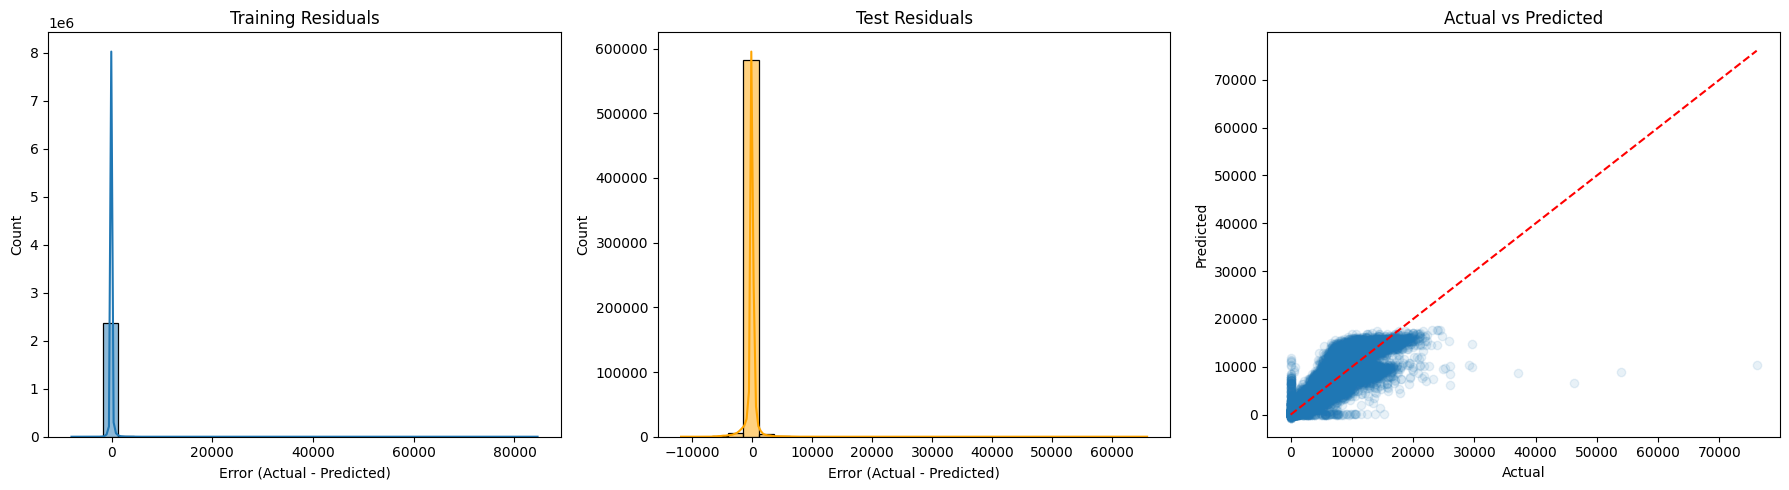

(52.52219009399414, 123.15673828125)

In [120]:
evaluate_model(X, y, model)

## 🚀 Model 2 — XGBoost (Baseline Version)

In this second model, we move beyond linear regression and use a gradient-boosted decision tree model: **XGBoost (XGBRegressor)**. XGBoost is well-suited for capturing non-linear relationships and interactions in time series data.

### ✅ What Was Done in This Version:
- Created a new Git branch: `xgboost-model`
- Switched the model from `LinearRegression` to `XGBRegressor`
- Kept the original date and promotion-based features
- **Added two key time-series features:**
  - `lag_1`: the previous day’s sales for the same store and product family
  - `rolling_7_mean`: 7-day moving average of sales (excluding the current day to avoid leakage)

### 📈 Evaluation Summary
- Used the same `evaluate_model()` function for consistency
- XGBoost produced a significantly lower training MAE compared to the linear model
- Some overfitting observed, but overall performance on test data improved

This version sets the foundation for further feature enrichment (e.g., rolling standard deviation, max, min), which we will add in the next iteration.


In [121]:
# 7 and 14 day lag features
train_data['lag_7'] = train_data.groupby(group_cols)['sales'].shift(7)
train_data['lag_14'] = train_data.groupby(group_cols)['sales'].shift(14)

# Rolling 7-day standard deviation (volatility)
train_data['rolling_7_std'] = (
    train_data
    .groupby(['store_nbr', 'family'])['sales']
    .transform(lambda x: x.shift(1).rolling(7).std())
)

# Rolling 7-day max (peak demand)
train_data['rolling_7_max'] = (
    train_data
    .groupby(['store_nbr', 'family'])['sales']
    .transform(lambda x: x.shift(1).rolling(7).max())
)

# Rolling 7-day min (demand dips)
train_data['rolling_7_min'] = (
    train_data
    .groupby(['store_nbr', 'family'])['sales']
    .transform(lambda x: x.shift(1).rolling(7).min())
)


In [122]:
train_data = train_data.dropna(subset=['lag_7', 'lag_14', 'rolling_7_std', 'rolling_7_max', 'rolling_7_min'])

In [125]:
X = train_data.drop(['sales', 'target', 'id', 'date', 'family'], axis=1)
y = train_data['target']

Training MAE: 52.30
Test MAE: 116.82


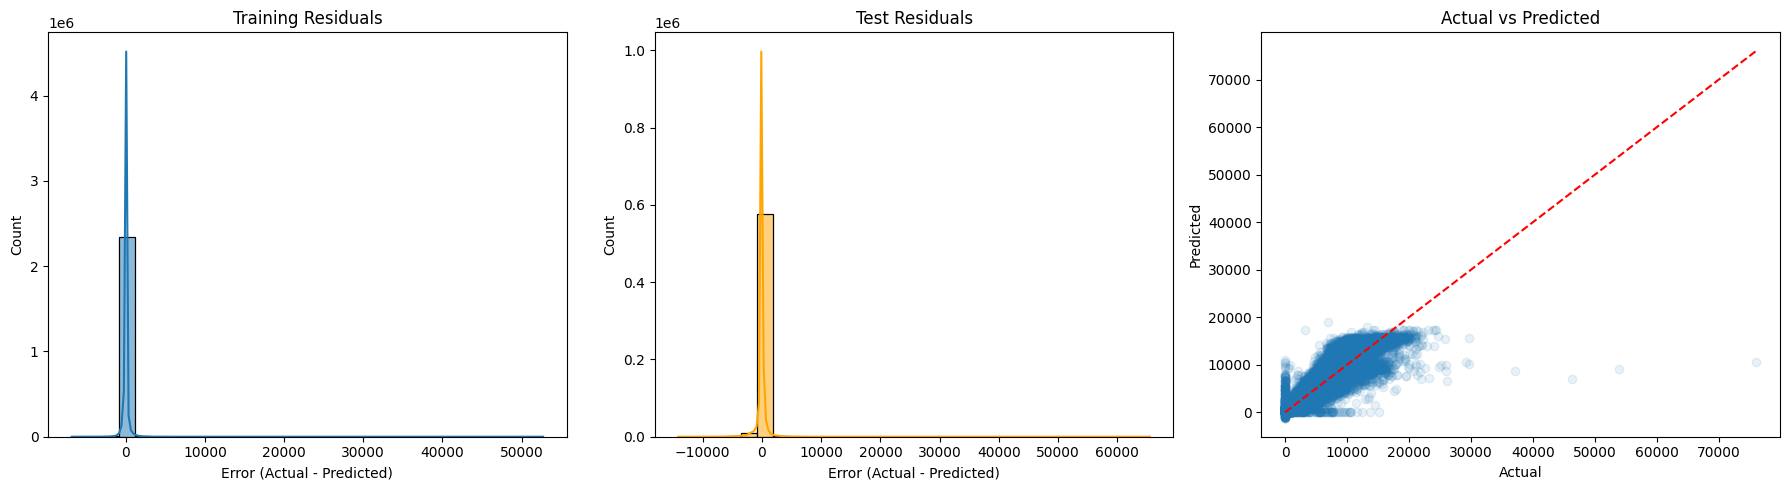

(52.30146408081055, 116.82279968261719)

In [126]:
evaluate_model(X, y, model)

## 🔁 Model 2.1 XGBoost with Extended Time Series Features

In this version, we expanded on the baseline XGBoost model by introducing additional time series features designed to help the model understand recent volatility, spikes, and dips in sales behavior.

### 🆕 New Features Added:
- `lag_7`: Sales value from 7 days ago
- `lag_14`: Sales value from 14 days ago
- `rolling_7_std`: Standard deviation over the past 7 days (volatility)
- `rolling_7_max`: Maximum sales in the past 7 days (peak detection)
- `rolling_7_min`: Minimum sales in the past 7 days (dip detection)

These were created per `store_nbr` and `family` group using `.groupby().transform(...)` logic with a `shift(1)` to avoid data leakage.

### 📈 Evaluation Summary
| Metric    | Baseline XGBoost | Improved XGBoost | Change |
|-----------|------------------|------------------|--------|
| Train MAE | 52.52            | 52.30            | 🔽 Slightly better |
| Test MAE  | 123.16           | 116.82           | 🔽 **Significant improvement** |

The added features helped the model generalize better to unseen data, indicating that these engineered temporal patterns are meaningful predictors.

---

In the next iteration, we consider encoding categorical variables (like `family`) or tuning the model’s hyperparameters.
